In [104]:
from tqdm import tqdm
import numpy as np
from requests import get
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initial cleanup

In [105]:
#Loading the data and looking at sample size
path = '/Users/zoeshleifer/cs4/titanic/train.csv'
df = pd.read_csv(path).drop(['PassengerId'],axis=1)
print('Passengers:', df.shape[0])
og_df = df.copy()
df.head()

Passengers: 891


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [106]:
# We need look for empty cells and decide how to fix them
df.isnull().sum() #This shows the number of empty cells for each column

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

 - Cabin - 687 nulls is our worst offender.   
 - Age - 177 is the only other problem (will be important to fill).  

_As we explore the data, we will get a better sense of how to deal with these_

In [107]:
df['Embarked']

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

In [108]:
# We add a numeric Sex column for easy manipulation
sex_map = {'female':1, 'male':0}
df['bin_sex']=df['Sex'].map(sex_map)
emb_map = {'C':0,'S':1,'Q':2}
df['bin_emb']=df['Embarked'].map(emb_map)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9469a81d0>,
      dtype=object)

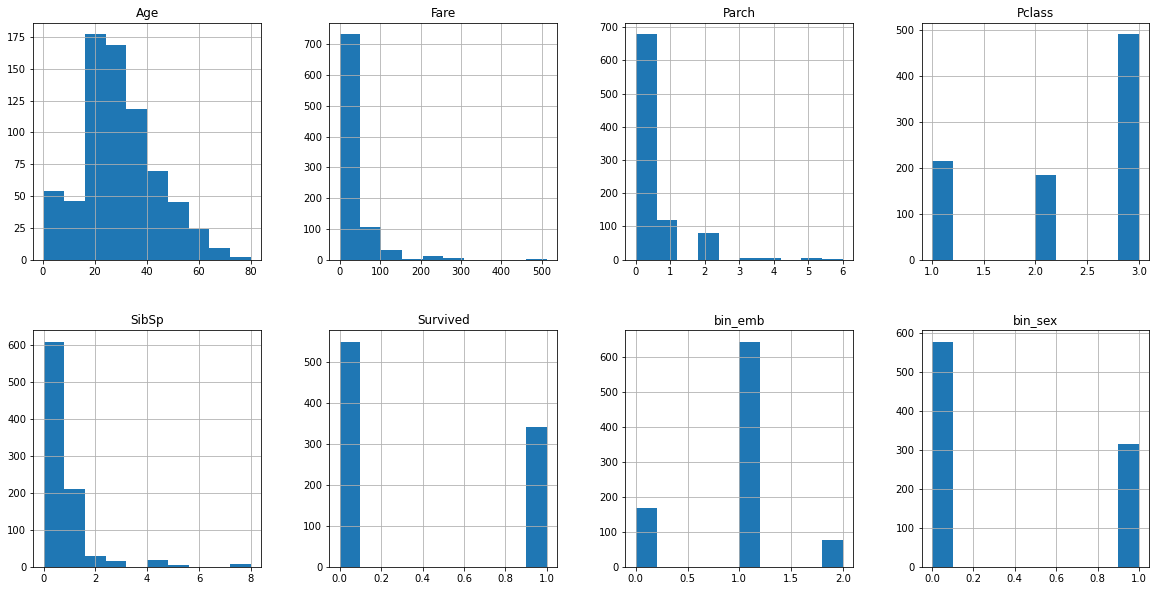

In [109]:
fig, ax = plt.subplots(2,4,figsize= (20,10))
df.hist(ax=ax)

**Sibling Count, Parent/Child Count, and Embarked Port seem to have pretty bad class balance. We can look into those to see if we can still get any information. First, let's look into the non-numeric columns:**

# Using Names for Titles, Age, and Family Structure
We can try and get meaning from the name column by looking at the titles

In [110]:
df['titles'] = og_df['Name'].map(lambda x: x.split(',')[1].split(' ')[1])

We look at the number of people with each title...

In [111]:
df['titles'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Capt.          1
Mme.           1
Sir.           1
Lady.          1
Jonkheer.      1
Ms.            1
the            1
Don.           1
Name: titles, dtype: int64

Meet the Countess:

In [112]:
df.loc[df['titles'] == 'the']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,bin_sex,bin_emb,titles
759,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B77,S,1,1.0,the


We want to know if these titles give us any additional information which we are not getting from Age and Class. Especially among men which seem to have fewer obvious important factors. 

Apparently boys were refered to as "Master" before they "entered society?" Let's see how they did on the titanic:

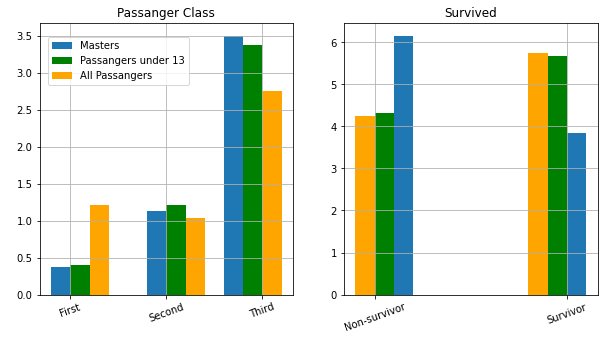

In [113]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax = [x for x in axes]
ax[0].set_title('Passanger Class')
df['Pclass'].loc[df['Name'].map(lambda x: x.split('.')[0].split(' ')[1]) == 'Master'].hist(ax=ax[0],density=True,label='Masters')
(df['Pclass']+.2).loc[df['Age'] <= 12].loc[df['bin_sex'] == 0].hist(ax = ax[0],density=True,color='Green',label='Passangers under 13')
(df['Pclass']+.4).hist(ax=ax[0],density=True,color='orange',label='All Passangers')
plt.sca(ax[0])
plt.xticks([1.2, 2.2, 3.2], ['First', 'Second', 'Third'],rotation=20)

s_mast= df['Survived'].loc[df['Name'].map(lambda x: x.split('.')[0].split(' ')[1]) == 'Master']
s_mast.hist(ax=ax[1],color='orange',density=True)
(df['Survived']+.2).hist(ax = ax[1],density=True)
(df['Survived']+.1).loc[df['Age'] <= 12].loc[df['bin_sex'] == 0].hist(ax = ax[1],density=True,color='Green')
ax[1].set_title('Survived')
#ticks = plt.xticks(ticks= [0.0,1.0], labels = ['Non-survivors''Survivors'])
plt.sca(ax[1])
plt.xticks([0.1, 1.1], ['Non-survivor','Survivor'], rotation=20)
fig.legend(loc = (.08,.75))
plt.show()

It turns out "Masters" are all boys under the Age of 13, so we don't get additional information from this title. However, we did learn that the honorifics are a good proxy for age. This is really useful because we have 177 passangers without age data. To fill empty age slots, we will draw from a normal distributions centered at the mean of the group. 

In [114]:
missing_age_hono = df.loc[og_df['Age'].isnull()].groupby('titles')
no_nan = df.loc[~og_df['Age'].isnull()].groupby('titles')
medians = {}
for group, gindex in missing_age_hono.groups.items():
    sample_ages = og_df['Age'].loc[no_nan.groups[group]]
    df['Age'].loc[gindex] = np.floor(np.random.normal(np.mean(sample_ages),np.std(sample_ages)/3, len(gindex)))

/Users/zoeshleifer/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Now that we have Age filled in, we can look into the Sibiling, Parent, Ticket, Cabin, and Name columns to split our passengers into family units. This will be a bit of a puzzle. 

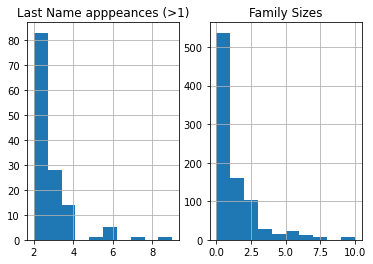

In [185]:
fig, ax = plt.subplots(1,2)
df['fam_names'] = df['Name'].map(lambda x: x.split(',')[0])
df['fam_names'].value_counts().head(133).hist(ax=ax[0])
ax[0].set_title('Last Name apppeances (>1)')
ax[1].set_title('Family Sizes')
df['fam_size'] = df['SibSp']+df['Parch']
df['fam_size'].hist(ax=ax[1])
plt.show()

In [206]:
# Under 18 with family on the ship
df.loc[(df['fam_size']>0)& (df['Age']<18)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,bin_sex,bin_emb,titles,fam_size,fam_names
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0,1.0,Master.,4,Palsson
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1,0.0,Mrs.,1,Nasser
10,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,1,1.0,Miss.,2,Sandstrom
16,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q,0,2.0,Master.,5,Rice
24,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.0750,NaN,S,1,1.0,Miss.,4,Palsson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,S,0,1.0,Master.,6,Andersson
852,0,3,"Boulos, Miss. Nourelain",female,9.0,1,1,2678,15.2458,NaN,C,1,0.0,Miss.,2,Boulos
853,1,1,"Lines, Miss. Mary Conover",female,16.0,0,1,PC 17592,39.4000,D28,S,1,1.0,Miss.,1,Lines
863,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,11.0,8,2,CA. 2343,69.5500,NaN,S,1,1.0,Miss.,10,Sage


On to numeric columns/ categorical data, we can explore relationships between Passenger Class, Age, and Survival.

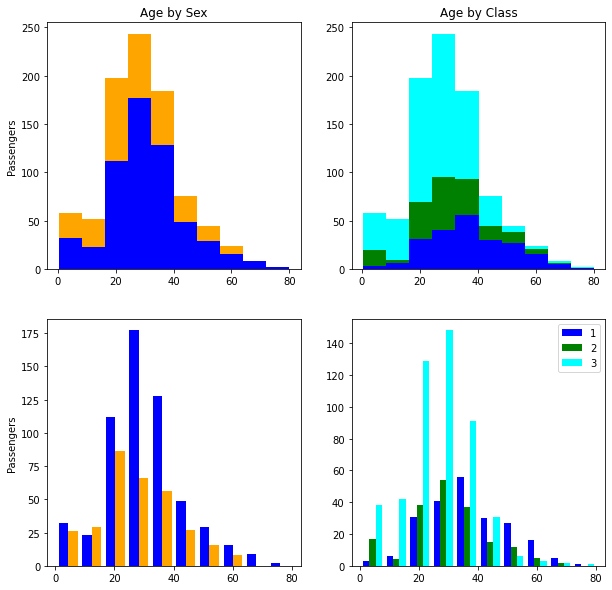

In [381]:
import numpy as np
import matplotlib.pyplot as plt
x,y = [df['Age'].loc[df['bin_sex']==x] for x in [0,1]]
x1,x2,x3 = [df['Age'].loc[df['Pclass']==x] for x in [1,2,3]]
bins = np.linspace(0, 8)
fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = [y for x in axes for y in x]
axes[0].hist([x, y],label=['male', 'female'],color=['blue','orange'],stacked=True)
axes[2].hist([x, y],label=['male', 'female'],color=['blue','orange'])
axes[1].hist([x1, x2,x3],label=['1', '2','3'],color=['blue','green','cyan'],stacked=True)
axes[3].hist([x1, x2,x3],label=['1', '2','3'],color=['blue','green','cyan'])
plt.legend(loc='upper right')
axes[0].set_title('Age by Sex')
axes[0].set_ylabel('Passengers')
axes[2].set_ylabel('Passengers')
axes[1].set_title('Age by Class')
plt.show()

In [382]:
def get_sur_rates(df_sub):
    bins = np.arange(0,90,10)
    df_sub['age_bins'] = pd.cut(df_sub['Age'],bins,include_lowest=True)
    sur_rates = {}
    group_sizes = []
    age_groups = df_sub.groupby('age_bins').groups
    for g, gindex in age_groups.items():
        if len(gindex>0):
            sur_rate = df_sub['Survived'].loc[gindex].sum()/len(gindex)
            sur_rates[g.left] = sur_rate
            group_sizes.append(len(gindex))
    return sur_rates,group_sizes

In [415]:
def sur_sers(sers): return list(map(lambda ser : get_sur_rates(df.loc[ser.index]), sers))
def make_scat(survs,labels,sub):
    for i, surs in enumerate(survs):
            x_vals, y_vals = list(surs[0].keys()),list(surs[0].values())
            sns.lineplot(x_vals, y_vals,ax=sub)
            sub.scatter(x_vals,y_vals,s=surs[1],label=labels[i])
    sub.legend()
    sub.set_xlabel('Age')

In [421]:
sex_surv = sur_sers([x,y])
class_surv = sur_sers([x1,x2,x3])
men_split = sur_sers([x.loc[df['bin_sex'].loc[x.index] == 0] for x in [x1,x2,x3]])
fen_split = sur_sers([x.loc[df['bin_sex'].loc[x.index] == 1] for x in [x1,x2,x3]])

Dot sizes are Sample sizes


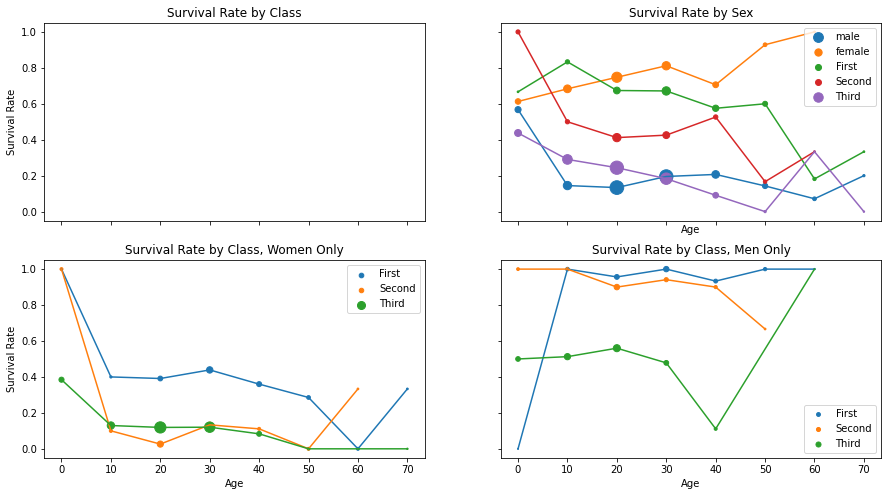

In [444]:
fig, [[tl,tr],[bl,br]] = plt.subplots(2,2,figsize=(15,8),sharex = True,sharey=True)
make_scat(sex_surv,['male','female'],tr)
charts = [tr,br,bl]
for i,chart in enumerate([class_surv,fen_split,men_split]):
    make_scat(chart,['First','Second','Third'],charts[i])
[x.set_ylabel('Survival Rate') for x in [bl,tl]]
titles = ['Survival Rate by Class',
 'Survival Rate by Sex',
 'Survival Rate by Class, Women Only',
 'Survival Rate by Class, Men Only']
[x.set_title(titles[i]) for i,x in enumerate([tl,tr,bl,br])]
print('Dot sizes are Sample sizes')